## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy.optimize import curve_fit
import cv2
%matplotlib inline

## Helper Functions

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
    #return weighted_img(masked_image, mask, α=0.18, β=1., γ=0.)


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    
    for line in lines:
        x1,y1,x2,y2 = line
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    lines = lines[:, 0, :] # stripe dimension not bein used 
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Modified Hough_Lines

In [18]:
# Fit line algorithm
def f(x, A, B): 
    return A*x + B

# Improved version of 'hough_lines', to draw only two lines, i.e., left and right lanes. 
def detect_lanes(img, rho, theta, threshold, min_line_len, max_line_gap, left=True):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    if lines is None:
        blank = np.zeros_like(img)
        A = np.dstack((blank,blank,blank))
        return A
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    lines = lines[:, 0, :] # stripe dimension not being used 
    
    # Calculate slop of every line, remove those that fall out of desired angle. Also test for left or right
    # left: slope < 0 
    # right: slope > 0
    new_lines = []
    min_slope = 0.55
    for i in range(len(lines)):
        x1, y1, x2, y2 = lines[i]
        slope = (y2 - y1)/(x2 - x1)
        #print(lines[i])
        #print(slope)
        if abs(slope) > min_slope:
            if (left and slope < 0) or (not left and slope > 0): 
                new_lines.append([x1, y1, x2, y2])
                
    lines = new_lines
    
    # If no lines selected, Try again...
    if len(lines) == 0:
        min_slope = 0.50
        for i in range(len(lines)):
            x1, y1, x2, y2 = lines[i]
            slope = (y2 - y1)/(x2 - x1)
            #print(lines[i])
            #print(slope)
            if abs(slope) > min_slope:
                if (left and slope < 0) or (not left and slope > 0): 
                    new_lines.append([x1, y1, x2, y2])
        lines = new_lines
    
    # If no lines selected still, give up.
    if len(lines) == 0:
        blank = np.zeros_like(img)
        A = np.dstack((blank,blank,blank))
        return A
    
    ### -------- DRAW HOUGH LINES
    #draw_lines(line_img, lines, thickness=5)
    #return line_img
    ### --------
                    
    x1, y1, x2, y2 = lines[0]
    A,B = curve_fit(f, [x1, x2], [y1, y2])[0]
    line_parameters= [[A,B]]
    counter = [0]
    
    for i in range(len(lines)):
        x1, y1, x2, y2 = lines[i]
        A,B = curve_fit(f, [x1, x2], [y1, y2])[0]
        added = False
        for j in range(len(line_parameters)):
            M = line_parameters[j]
            # Test if new line is compatible with previous line
            if abs(A - M[0]) < 1.5 and abs(B - M[1]) < 50:
                added = True
                
                # Average parameter values
                M[0] = (counter[j]*M[0]+A)/(counter[j]+1)
                M[1] = (counter[j]*M[1]+B)/(counter[j]+1)
                counter[j] += 1
                
        if not added:
            line_parameters.append([A, B])
            counter.append(1)
            
    #if(len(counter) == 1):
    #    draw_lines(line_img, lines, thickness=5)
    #    return line_img
    
    # Pick the most counted line parameters
    n_lines =[]
    
    indices = np.array(counter).argsort()[-2:]
    M0 = line_parameters[indices[0]] 
    
    # Draw straigh lines - using parameters - for different values of y (y = 3/5*height and y = height-1)
    y_top = int(3/5*img.shape[0])
    y_bot = int(img.shape[0]) - 1
    
    # x = y/A - B/A
    x_top = int(y_top/M0[0] - M0[1]/M0[0])
    x_bot = int(y_bot/M0[0] - M0[1]/M0[0])
    
    # clip value to boundaries
    x_bot = np.clip(x_bot, 0, img.shape[1]-1)
    x_top = np.clip(x_top, 0, img.shape[1]-1)
    
    n_lines.append([x_bot, y_bot, x_top, y_top])
    
    draw_lines(line_img, n_lines, thickness=5)
    #draw_lines(line_img, lines, thickness=5)
    return line_img

## Build a Lane Finding Pipeline



In [19]:
def plot_lanes(image):
    
    # 1. grayscale
    gray = grayscale(image)
    
    # 2. Blur
    kernel_size = 3
    gray_blur = gaussian_blur(gray, kernel_size)
    
    # 3. Find edges using Canny
    low_threshold = 70
    high_threshold = 100
    edges_image = canny(gray_blur, low_threshold, high_threshold)
    
    # ---
    #backtorgb = cv2.cvtColor(edges_image,cv2.COLOR_GRAY2RGB)
    #final_image = weighted_img(backtorgb, image, α=0.9, β=1., γ=0.)
    #return final_image
    # ---
    
    # 4. Mask ROI left and right
    bot_left = (0,gray.shape[0])
    bot_right = (gray.shape[1],gray.shape[0])
    
    top_left = (int(gray.shape[1]*0.4), int(gray.shape[0]*0.6))
    top_right = (int(gray.shape[1]*0.6), int(gray.shape[0]*0.6))
    
    mid_top = (gray.shape[1]//2, int(gray.shape[0]*0.6) )
    mid_bot = (gray.shape[1]//2, gray.shape[0])
    
    vertices_left = np.array([[bot_left, top_left, mid_top, mid_bot]], dtype=np.int32)
    vertices_right = np.array([[bot_right, top_right, mid_top, mid_bot]], dtype=np.int32)
    
    edges_masked_left = region_of_interest(edges_image, vertices_left)
    edges_masked_right = region_of_interest(edges_image, vertices_right)
    
    # 5. Apply hough transform to find lines
    
    rho = 2 # pixels resolution 
    theta = np.pi/180 # 1 degree resolution
    #threshold = 15 # number of intersections to be considered a line.
    threshold = 4
    min_line_len = 40 # 
    #max_line_gap = 20 #
    max_line_gap = 10 #
    line_image = np.copy(image)*0 #creating a blank to draw lines on

    lines_img_left = detect_lanes(edges_masked_left, rho, theta, threshold, min_line_len, max_line_gap, left = True)
    lines_img_right = detect_lanes(edges_masked_right, rho, theta, threshold, min_line_len, max_line_gap, left = False)
    
    # 6. Overlay
    '''
    lines_img_left = lines_img_left[:,:,0]
    lines_img_right = lines_img_right[:,:,0]
    channel = np.zeros_like(gray)
    backtorgb_left = np.dstack((channel, channel, lines_img_left))
    backtorgb_right = np.dstack((lines_img_right, channel, channel))
    both_lanes = weighted_img(backtorgb_left, backtorgb_right, α=1.0, β=1., γ=0.)
    final_image = weighted_img(both_lanes, image, α=0.9, β=1., γ=0.)
    return final_image
    '''
    both_lanes = weighted_img(lines_img_left, lines_img_right, α=1.0, β=1., γ=0.)
    final_image = weighted_img(both_lanes, image, α=0.9, β=1., γ=0.)
    return final_image


## Testing on images

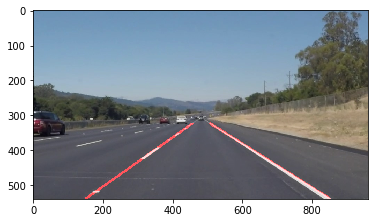

In [20]:
# Testing on images
# Save on test_images_output 

# 0. Retrieve images
import os
folder = "test_images/"
folder_out = "test_images_output/"
image_names = os.listdir(folder)

for image_name in image_names:
    image = mpimg.imread(folder+image_name)
    result = plot_lanes(image)
    
    cv2.imwrite(folder_out+image_name, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))   

image = mpimg.imread(folder+image_names[1])
plt.imshow(image)
result = plot_lanes(image)
plt.imshow(result)


## Test on Videos

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    result = plot_lanes(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [22]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████████████████████████████████████████████████▊| 221/222 [00:05<00:00, 42.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 5.68 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [23]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)

clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████████████████████████████████████████████████▉| 681/682 [00:15<00:00, 42.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 16.4 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [21]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████████████████████████████████████████████████| 251/251 [00:11<00:00, 25.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 12.1 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))